<div class="alert alert-success">
<h2> <b> Обработка естественного языка </b> <font size="7" color=blue> 👅 </font></h2>
</div>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Модель-бустинга" data-toc-modified-id="Модель-бустинга-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель бустинга</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

***Задача:***<br/>
Построить модель, которая умеет классифицировать комментарии на позитивные и негативные.

Метрика качества - *F1*.

***Описание данных:***<br/>
Данные находятся в файле `toxic_comments.csv`. Столбец *text* содержит текст комментария, а *toxic* — разметка о токсичности (целевой признак).

---

## Анализ данных

In [ ]:
import pandas as pd
import numpy as np
import time
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv',
                    index_col=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
data[data.toxic == 1].head(10)

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1
55,Stupid peace of shit stop deleting my stuff as...,1
56,=Tony Sidaway is obviously a fistfuckee. He lo...,1
58,My Band Page's deletion. You thought I was gon...,1


<AxesSubplot:ylabel='toxic'>

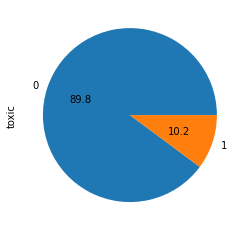

In [ ]:
# Посмотрим сбалансированность классов в целевом признаке

data['toxic'].value_counts().plot(kind='pie', autopct='%.1f')

***Заметки:***
* Текст на английском языке;
* Признаки перемешаны;
* Классы несбалансированны;
* Данных много, можно сделать уменьшение выборки класса "0" на 80%, тогда останется примерно 45000 строк в соотношении 1 к 2 (если будет плохая метрика, можно ещё попробовать увеличить класс "1" в 2 раза).

---

## Подготовка

In [ ]:
# Выделим признаки и целевой признак.

target = data.toxic
features = data.text

In [ ]:
# Создадим функцию уменьшения выборки.

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
                                    + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
                                   + [target_ones])

    features_downsampled, target_downsampled = shuffle(
            features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled.reset_index(drop=True),\
           target_downsampled.reset_index(drop=True)

In [ ]:
# Разделим данные на обучающую, валидационную и тестовую выборки.

X_train_, X_, y_train_, y_ = train_test_split(features,
                                              target,
                                              test_size=.3,
                                              stratify=target,
                                              random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_,
                                                    y_,
                                                    test_size=.5,
                                                    stratify=y_,
                                                    random_state=12345)

X_train_.shape, y_train_.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((111504,), (111504,), (23894,), (23894,), (23894,), (23894,))

In [ ]:
# Исправим дисбаланс в обучающей выборке,
# валидировать и тестировать будем с оригинальным дисбалансом.

X_train, y_train = downsample(X_train_, y_train_, 0.2)
X_train.shape

(31365,)

In [ ]:
# Преобразовывать текст в Unicode для английского языка необязателено для работы моделей,
# кроме того это занимает лишнюю память и может приводить к падению ядра.

# corpus_train = X_train.values.astype('U')
# corpus_test = X_test.values.astype('U')

In [ ]:
# Создадим корпус: преобразуем столбец text в список текстов.

corpus_train = X_train.values
corpus_valid = X_valid.values
corpus_test = X_test.values

In [ ]:
# Создадим объект класса TfidfVectorizer.

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Преобразуем текстовые признаки по методу TF-IDF.

X_train_tf_idf = tf_idf.fit_transform(corpus_train)
X_valid_tf_idf = tf_idf.transform(corpus_valid)
X_test_tf_idf = tf_idf.transform(corpus_test)

---

## Обучение

### Логистическая регрессия

In [ ]:
# Обучим модель логистической ригрессии.

model = LogisticRegression(class_weight='balanced',
                           random_state=12345)
model.fit(X_train_tf_idf, y_train)

LogisticRegression(class_weight='balanced', random_state=12345)

In [ ]:
# Проверка модели на валидационной выборке.

predict_lr_valid = model.predict(X_valid_tf_idf)

print(f'Значение метрики F1 на обучающей выборке: '
      f'{round(f1_score(y_valid, predict_lr_valid), 2)}')

Значение метрики F1 на обучающей выборке: 0.71


In [ ]:
# Зададим параметры кросс-валидации.

cv = StratifiedKFold(3, shuffle=True, random_state=12345)

In [ ]:
# Проверка метрики F1 модели на кросс-валидации.

f1_train = cross_val_score(model,
                           X_train_tf_idf,
                           y_train,
                           cv=cv,
                           scoring='f1')
print(f'Значение метрики F1 на кросс-валидации: '
      f'{round(min(f1_train), 2)}')

Значение метрики F1 на кросс-валидации: 0.85


In [ ]:
# Используем пайплайн вместе с кросс-валидацией

reg = LogisticRegression(class_weight='balanced',
                         random_state=12345)
vect = TfidfVectorizer(stop_words=stopwords)

pipe = Pipeline([
                 ('vect', vect),
                 ('reg', reg)
])
f1_pipe = cross_val_score(pipe,
                          corpus_train,
                          y_train,
                          cv=cv,
                          scoring='f1')


In [ ]:
f1_pipe

array([0.86320627, 0.85334419, 0.855378  ])

---

### Модель бустинга

In [ ]:
# Обучим модель бустинга.

cat_model = CatBoostClassifier(iterations=10,
                               loss_function='Logloss', # нет встроенной метрики F1
                               verbose=False)
# catboost.fit(X_train_tf_idf, y_train,
#              verbose=False, plot=True)

# Cоздаем словарь с гиперпараметрами
grid = {'iterations': [10,50, 100],
        #'learning_rate': [0.03,0.1],
        #'depth': [8, 10]
        }

cat_grid = cat_model.grid_search(grid,
                                 X=X_train_tf_idf,
                                 y=y_train,
                                 cv=cv,
                                 plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5905433512
bestIteration = 9

0:	loss: 0.5905434	best: 0.5905434 (0)	total: 15.4s	remaining: 30.9s

bestTest = 0.4722614987
bestIteration = 49

1:	loss: 0.4722615	best: 0.4722615 (1)	total: 56.2s	remaining: 28.1s

bestTest = 0.4265190297
bestIteration = 99

2:	loss: 0.4265190	best: 0.4265190 (2)	total: 2m 18s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.423154571
bestIteration = 99

Training on fold [1/3]

bestTest = 0.4268953943
bestIteration = 99

Training on fold [2/3]

bestTest = 0.4301041519
bestIteration = 99



In [ ]:
print('Лучший результат Logloss: {:.2}'.format(
                    cat_model.best_score_['learn']['Logloss']))
print(f"Лучшие гиперпараметры: {cat_grid['params']}")

Лучший результат Logloss: 0.24
Лучшие гиперпараметры: {'iterations': 100}


In [ ]:
# Проверка модели на валидационной выборке.

predict_cat_valid = cat_model.predict(X_valid_tf_idf)

print(f'Значение метрики F1 на обучающей выборке: '
      f'{round(f1_score(y_valid, predict_cat_valid), 2)}')

Значение метрики F1 на обучающей выборке: 0.76


***Заметки:***    
Если делать кросс-валидацию на признаках TF-IDF, то произойдет **утечка тестовых данных**. Чтобы не попадала информация о словах из тестовой выборки в тренировочную, можно обучить `TfidfVectorizer` на тренировочной выборке, после чего трансформировать тестовую выборку. <br>
При кросс-валидации тренировочная выборка делится на тренировочные фолды и тестовый фолд, при этом `TfidfVectorizer` обучается на всех фолдах в сумме. Решить проблему можно использую Pipelines, где получение признаков `TF-IDF` происходит каждый раз, когда выборка делится на тренировочные и тестовые фолды.

```python
from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', SGDClassifier()),
])
parameters = [{
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3),)  
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80)
},{
    'vect': (CountVectorizer(),)
    # count_vect_params...
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80)
}]

grid_search = GridSearchCV(pipeline, parameters)
```

</div>



---

## Выводы

***Заметки:***
* Лучшее занчение метрики F1 на валидационной выборке у модели бустинга (F1 = 0.76);
* Балансировка классов методом "уменьшения большего класса" приводит к заметному улучшению метрики F1, кроме использовалась балансировка весов class_weight='balanced' при обучении логистической регрессии.

In [ ]:
%%time
# Проверка модели бустинга на тестовой выборке.

predictions_cat = cat_model.predict(X_test_tf_idf)
f1_cat_test = f1_score(y_test, predictions_cat)

print(f'Значение метрики F1 на тестовой выборке: '
      f'{round(f1_cat_test, 2)}')

Значение метрики F1 на тестовой выборке: 0.76
CPU times: user 172 ms, sys: 15.1 ms, total: 187 ms
Wall time: 185 ms


***Заключение:***
Модель бустинга имеет на тестовой выборке значение метрики F1 = 0.76, что удовлетворяет заданному критерию точности.

***Вывод:***

Модель CatBoostClassifier с предобработкой признаков по методу TF-IDF даёт хорошие результаты и может быть использованна для классифицирования комментариев на позитивные и негативные.


---

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны